In [2]:
# all the import and definitions
import site
site.addsitedir('./src')
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import numpy as np
from datetime import datetime
from src.throttle import *
from src.TwoProb import *
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as tt
import arviz as az

# Understanding Data through Bayesian Inference and Probabilistic Programming 

<p></p>

<center>
Damien Zufferey

<img src="data/mpi-sws-logo.svg" width="30%"/>

</center>

<p></p>

<center>
2020.12.08, Université de Neuchâtel
</center>

- have a live kernel
- clean the output of the short examples
- run the cells with wigdets and inference for larger example
- cell toolbar to `None`
- get latest data for covid map
- erase chalkboard 

# Outline

1. Data science, some context
2. The inference problem and Bayes rule
3. Probabilistic programming

In this lecture, I assume that people are familar with basic probabilities and programming.

### Slides

https://github.com/dzufferey/presentations/tree/master/2020_12_Neuchatel_PP

The code in the slide is actual running code.

In [34]:
time_button = widgets.Button(description='Running live code:')
time_out = widgets.Output()
def time_button_clicked(_):
    with time_out:
        time_out.clear_output()
        print(datetime.now().strftime("click @ %Y-%m-%d %H:%M"))
time_button.on_click(time_button_clicked)
widgets.HBox([time_button,time_out])

# Life Cycle of Data

<center>
    
<img src="data/data_lifecycle.svg" width="40%"/>
</center>

# Enabling of Data Science

- __Availability of data__: Big Data, internet, IOT, ...
- __Infrastructure__: IaaS (cloud), GPGPU, tooling, ...
- __Algorithms__: machine learning, AI, ...

# The Skills of a Data Analyst

#### Drew Conway’s Venn Diagram of data science

<center>
    
<img src="data/Data_Science_VD.png" width="40%"/>
</center>


# Running Example: COVID-19

The "Hello World" example of Bayesian inference is the diagnostic of medical conditions...

In [38]:
import json
import pandas as pd
import os

with open("data/swiss-maps.json", 'r') as f:
    geo_json_data = json.load(f)

with open("data/COVID19Cases_geoRegion.csv", 'r') as f:
    covid_data = pd.read_csv(f)
    
cantons = ["ZH", "BE", "LU", "UR", "SZ",
           "OW", "NW", "GL", "ZG", "FR",
           "SO", "BS", "BL", "SH", "AR",
           "AI", "SG", "GR", "AG", "TG",
           "TI", "VD", "VS", "NE", "GE",
           "JU"]

dates = covid_data['datum'].unique()
dates.sort()

min_val = 0.0
max_val = 0.0

def getCases():
    global max_val
    cases = dict()
    for c in cantons:
        cases[c] = dict()
        byc = covid_data.loc[covid_data.geoRegion == c]
        # filling gaps
        byc = byc.fillna(method='pad')
        byc = byc.fillna(value={'mean7d': 0.0})
        # order by dates
        for d in dates:
            bd = byc.loc[byc.datum == d]
            nbr = bd['mean7d'].iat[0]
            pop = bd['pop'].iat[0]
            n = nbr / pop * 100000 # per 100'000
            nl = math.log(1+n)
            cases[c][d] = nl
            max_val = max(max_val, nl)
    return cases

cases = getCases()

#now the visualization
import folium
import folium.plugins
import branca.colormap as cm

linear = cm.LinearColormap(['green', 'yellow', 'red'], vmin=min_val, vmax=max_val).to_step(100)
linear.caption = "Covid Cases (mean 7d) per 100.000, logscale"

styledict = dict()
for c in cantons:
    styledict[c] = dict()
    for d in dates:
        dobj = datetime.strptime(d, "%Y-%m-%d")
        styledict[c][int(dobj.timestamp())] =  {
            'opacity': '0.6',
            'color': linear(cases[c][d])
          }

m = folium.Map(
    location=[46.8907, 8.2240],
    zoom_start=8,
    #tiles='Stamen Terrain',
    width=1200,
    height=600)
folium.plugins.TimeSliderChoropleth(
    geo_json_data,
    styledict,
    "Covid Cases (mean 7d) per 100'000, logscale"
).add_to(m)
m.add_child(linear)
pass

In [39]:
m #code is in the cell above (hidden from the presentation)

# Probabilistic Programming: Let people build model, the computer does the rest 

[Inferring change points in the spread of COVID-19 reveals the effectiveness of interventions](https://science.sciencemag.org/content/369/6500/eabb9789.full) by Dehning et al., Science, June 2020.

<center>

<img src="data/image5128.png" width="50%"/>
</center>
Image taken from the arxiv tech report.

# Inference Problem: How Data Influence Beliefs

Origin of Bayesian Inference: learning from experience, updating knowledge

$$ \text{Hypothesis}_i \xrightarrow{\text{cause/effect}} \text{Evidence} $$

$$ \text{Hypothesis}_i \xleftarrow{\text{inference}} \text{Evidence} $$

Bayesian probability: degree of certainty about an hypothesis.

# Crash Course in Probabilities

Let $A$ and $B$ be two events.

$A$ happens: $$P(A)$$

$A$ _does not_ happen: $$P(\neg A) = 1 - P(A)$$

$A$ and $B$ both happen: $$P(A \cap B)$$

$A$ or $B$ happen: $$P(A \cup B) = P(A) + P(B) - P(A \cap B)$$

$A$ happens knowing that $B$ did happen: $$P(A|B) = \frac{P(A \cap B)}{P(B)} ~~~~~~~~~~~~~~ \text{if} ~~ P(B) > 0$$

In [60]:
TwoProb()

TwoProb(children=(Box(children=(Output(),), layout=Layout(height='500px', width='68%')), VBox(children=(VBox(c…

# Deriving Bayes' Rule

Consider two events
- $H$: hypothesis
- $E$: evidence

#### How can we get to $P(H \cap E)$ ?

First $E$ happens then $H$ happens: $$P(H \cap E) = P(E) \cdot P(H | E)$$

<center>

<img src="data/probs_1.svg" width="48%"/>
</center>

First $H$ happens then $E$ happens: $$P(H \cap E) = P(H) \cdot P(E | H)$$

<center>

<img src="data/probs_2.svg" width="40%"/>
</center>

Together we have: $$P(E) \cdot P(H | E) = P(H) \cdot P(E | H)$$

## Bayes' Rule

$$ P(H|E) = \frac{P(H) \cdot P(E|H)}{P(E)} ~~~~~~~~~~~~ \text{if} ~~ P(E)>0 $$

The rules relates $P(E|H)$ (cause-effect model) and $P(H|E)$ what we know after observing $E$.

#### Interpretation
- $P(H)$: __prior__, initial degree of belief in $H$
- $P(H|E)$: __posterior__, degree of belief after observing $E$
- $\frac{P(E|H)}{P(E)}$: how much the observation supports the hypothesis.

# Bayes' Rule Example

$$P(H|E) = \frac{P(H) \cdot P(E|H)}{P(E)}$$

Covid test:
- $H$: has covid
- $E$: test is positive

Parts of the formula:
- $P(H)$ is the incidence rate in the population
- $P(E)$ in the fraction of positive test
- $P(E|H)$: true positive rate
- $P(H|E)$: has covid given a positive test

#### Gathering Data

- $P(H) = 0.1$ (For Geneva in late May, nearly 10% of people testing positive to antibody tests!)
- $P(E|H) = 0.8$  (20% of false negative)
- $P(E|\neg H) = 0.02 $ (false positive)

#### Computing $P(E)$

$P(E) = P(H) \cdot P(E|H) + P(\neg H) \cdot P(E|\neg H)$

$P(E) = 0.1 \cdot 0.8 + 0.9 \cdot 0.02 = 0.098 = 9.8\%$

#### Computing $P(H|E)$

$P(H|E) = \frac{P(H) \cdot P(E|H)}{P(E)} = \frac{ 0.1 \cdot 0.8}{0.098} = 0.82 = 82\%$

#### Interpretation:
- before the test: I have $10\%$ chance of having covid
- after a positive test: I have $82\%$ chance of having covid

Also interesting: $P(H| \neg E) = 0.3\%$

In that case, the test gives good results! (wait before premature celebration.)

# Inference on Complex Model with Probabilistic Programming

1. Explain how data are generated: cause-effect model as a program,
2. Push button: inference engine figures out the probabilities.

# Probabilistic Programming vs Other Paradigms

`o := f(i)`
* __"normal" programing__: given `f` and `i` computes `o`
* __probabilistic programming__: given `f` and `o` infers `i`
* __machine learning__: given `i` and `o` learns `f`

In [57]:
with pm.Model():
    s = pm.Bernoulli("HasCovid", 0.1)                    # prior
    testResult = s * 0.8 + (1 - s) * 0.02                # model
    pm.Bernoulli("TestResult", testResult, observed=1)   # observation ('1' is positive, '0' is negative)
    test_trace = pm.sample()                             # inference
np.average(test_trace["HasCovid"])                       # posterior

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [HasCovid]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


0.295

Zurich has $3.4\%$ seroprevalence, let's try with that.

Seroprevalence is the cummulative number, not the active cases.
Let us try even lower number.

## Using Probabilistic Programming

1. __Identification__: find the relevent elements.
2. __Modeling__: how the elements interact to produce the result.
3. __Inference__: feed the data
4. __Validation__: convergence of inference, quality of fit (simulation), visualisation, etc.
5. __Prediction__: extrapolation, loss function

## Example: Infering the Incidence with Tests and Testing Accuracy

In [44]:
# artificial test data: 20% of positive tests for 100 tests
n_test = 100
p_test =  20

In [45]:
with pm.Model() as model:
    i = pm.Uniform("incidence", 0, 1)                          # what we want to discover
    # data from PCR test in the UK (simplified model)
    truePositive = pm.Uniform("truePos", 0.67, 0.98)           # 2-33% false negative
    falsePositive = pm.Uniform("falsePos", 0.008, 0.04)        # 0.8-4% false positive
    # universe of the test 
    affected = pm.Bernoulli("affected", i, shape=n_test)       # people tested
    test1 = pm.Bernoulli("test1", truePositive, shape=n_test)  # chances if affected
    test2 = pm.Bernoulli("test2", falsePositive, shape=n_test) # chances if not affected

In [46]:
# for faster/better restult we need to set the initial point of the search closer to where we think it may be
# this does not affect the result but we get there faster
with model:
    i.tag.test_value = p_test / float(n_test)
    truePositive.tag.test_value = 0.8
    falsePositive.tag.test_value = 0.02
    affected.tag.test_value = np.random.binomial(1, i.tag.test_value, n_test)
    test1.tag.test_value = np.random.binomial(1, truePositive.tag.test_value, n_test)
    test2.tag.test_value = np.random.binomial(1, falsePositive.tag.test_value, n_test)

In [47]:
with model:
    # testing procedure: combine true and false positive to give the expected observation rate
    val = test1*affected + test2*(1 - affected)
    observed_proportion = pm.Deterministic("observed_proportion", pm.math.sum(val)/float(n_test))
    pm.Binomial("observation", n_test, observed_proportion, observed=p_test) 

In [48]:
# sanity check
observed_proportion.tag.test_value

array(0.19)

## Visualizing the model

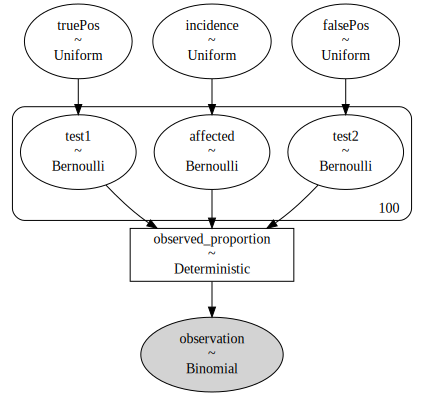

In [19]:
pm.model_to_graphviz(model)

# Running the Inference Algorithm

In [52]:
with model:
    trace = pm.sample(50000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [falsePos, truePos, incidence]
>BinaryGibbsMetropolis: [affected, test1, test2]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 1110 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [53]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
az.plot_dist(trace["incidence"], label="Incidence", ax=ax[0])
az.plot_dist(trace["truePos"], color="C2", label="True positive", ax=ax[1])
az.plot_dist(trace["falsePos"], color="C3", label="False Positive", ax=ax[2])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
np.average(trace["incidence"])

0.24147625011576423

In [54]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
az.plot_dist(trace["incidence"], trace["truePos"], ax=ax )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

## Probabilistic Programming in the Real World

About the COVID projection we saw earlier:

<center>

<img src="data/image5128.png" width="40%" style="display:inline; margin-right:30px;"/>
<img src="data/2004.01105.svg" width="40%" style="display:inline; margin-left:30px;"/>
</center>

Code available at: https://github.com/Priesemann-Group/covid19_inference/

<center>
    
<img src="data/covid-model-Priesemann.svg" width="100%"/>
</center>

## Some extra references:
- model taken from the `example_bundeslaender.ipynb` notebook
- https://www.youtube.com/watch?v=btHkSlePV5Q
- Picture of the projection from https://arxiv.org/abs/2004.01105

# Monty Hall Problem

<center>


<img src="data/Monty-MiddleCarSwitch.svg" width="40%"/>
</center>


In [59]:
@as_op(itypes=[tt.lscalar,tt.lscalar,tt.lscalar], otypes=[tt.lscalar])
def switch(car, guess, monty):
    possibleOpen = [i for i in range(0, 3) if i != car and i != guess]
    openDoor = possibleOpen[monty] if len(possibleOpen) > 1 else possibleOpen[0]
    guess2 = [i for i in range(0, 3) if i != openDoor and i != guess][0]
    return car == guess2
    
with pm.Model():
    car = pm.DiscreteUniform("car",0,2)
    guess = pm.DiscreteUniform("guess",0,2)
    monty = pm.DiscreteUniform("monty",0,1)
    #win = pm.Deterministic("win", pm.math.eq(car, guess))
    win = pm.Deterministic("win", switch(car, guess, monty))
    mh_trace = pm.sample()

np.average(mh_trace["win"])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [monty]
>Metropolis: [guess]
>Metropolis: [car]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


0.691

## Conclusion

<center>


<img src="data/conclusion.svg" width="80%"/>
</center>


# References

- [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) by Cameron Davidson-Pilon, 2015
- [Probabilistic Systems Analysis and Applied Probability](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-041-probabilistic-systems-analysis-and-applied-probability-fall-2010/) by John Tsitsiklis, 2011
- [Introduction to Computational Thinking and Data Science](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-0002-introduction-to-computational-thinking-and-data-science-fall-2016/) by Eric Grimson, John Guttag, and Ana Bell, 2016.
- [Probabilistic Programming: The What, Why and How](https://2020.splashcon.org/details/splash-2020-rebase/16/Probabilistic-Programming-The-What-Why-and-How) by Maria I. Gorinova, 2020.
- [The Data Science Venn Diagram](http://drewconway.com/zia/2013/3/26/the-data-science-venn-diagram) by Drew Conway, 2010. (image distributed under CC-BY-NC license)
- [Probabilistic programming in Python using PyMC3](https://peerj.com/articles/cs-55/) by John Salvatier, Thomas V. Wiecki, and Christopher Fonnesbeck, 2016

# Source for Code and Data

* [Inferring change points in the spread of COVID-19 reveals the effectiveness of interventions](https://science.sciencemag.org/content/369/6500/eabb9789.full) by Jonas Dehning, Johannes Zierenberg, F. Paul Spitzner, Michael Wibral, Joao Pinheiro Neto, Michael Wilczek, Viola Priesemann, June 2020.
* [Seroprevalence of anti-SARS-CoV-2 IgG antibodies in Geneva, Switzerland (SEROCoV-POP): a population-based study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)31304-0/fulltext) by Silvia Stringhini, Ania Wisniak, Giovanni Piumatti, Andrew S Azman, Stephen A Lauer, Hélène Baysson, David De Ridder, Dusan Petrovic, Stephanie Schrempft, Kailing Marcus, Sabine Yerly, Isabelle Arm Vernez, Prof Olivia Keiser, Samia Hurst, Klara M Posfay-Barbe, Didier Trono, Didier Pittet, Laurent Gétaz, François Chappuis, Isabella Eckerle, Nicolas Vuilleumier, Benjamin Meyer, Antoine Flahault, Laurent Kaiser, and Idris Guessous, June 2020.
* https://www.corona-immunitas.ch/en/
* [Impact of false-positives and false-negatives in the UK’s COVID-19 RT-PCR testing programme](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/895843/S0519_Impact_of_false_positives_and_negatives.pdf) by Carl Mayers and Kate Baker, June 2020
* [COVID-19 Suisse](https://www.covid19.admin.ch/en/overview) Office fédéral de la santé publique OFSP